In [23]:
import pandas as pd
from pathlib import Path
import os
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss, brier_score_loss, confusion_matrix
import seaborn as sns

def get_dataset_reference():
    current_folder = Path(os.getcwd())
    model_folder = current_folder.parent
    webscrapping_folder = model_folder.parent
    return Path(webscrapping_folder, "matches", "datasets")

In [9]:
filename = "5000.csv"
df = pd.read_csv(f"{get_dataset_reference()}\\{filename}")
df

,RegularTime,SpikeTime,MapName,FinalWinner,RoundID,MatchID,RoundNumber,RoundTime,ATK_loadoutValue,ATK_weaponValue,...,DEF_remainingCreds,DEF_operators,DEF_Initiator,DEF_Duelist,DEF_Sentinel,DEF_Controller,Team_A_ID,Team_A_Name,Team_B_ID,Team_B_Name
0,0,0,Split,1,107567,6197,1,0,3900,0,...,0,0,1,2,1,1,279,Luminosity Gaming,32,Equinox Esports
1,15,0,Split,1,107567,6197,1,15494,3900,0,...,0,0,1,2,1,0,279,Luminosity Gaming,32,Equinox Esports
2,16,0,Split,1,107567,6197,1,16500,3900,0,...,0,0,1,1,1,0,279,Luminosity Gaming,32,Equinox Esports
3,26,0,Split,1,107567,6197,1,25999,3900,0,...,0,0,1,1,0,0,279,Luminosity Gaming,32,Equinox Esports
4,32,0,Split,1,107567,6197,1,32331,3900,0,...,0,0,0,1,0,0,279,Luminosity Gaming,32,Equinox Esports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898184,0,7,Icebox,0,494951,31800,14,21175,8150,5300,...,100,0,1,1,1,0,4307,Project ABC,4308,Havik Esports
898185,0,8,Icebox,0,494951,31800,14,22281,4600,3200,...,100,0,1,1,1,0,4307,Project ABC,4308,Havik Esports
898186,0,9,Icebox,0,494951,31800,14,23697,2400,1600,...,100,0,1,1,1,0,4307,Project ABC,4308,Havik Esports
898187,0,18,Icebox,0,494951,31800,14,31960,0,0,...,100,0,1,1,1,0,4307,Project ABC,4308,Havik Esports


# <font color='green'>Exploratory Analysis</font>

<AxesSubplot:>

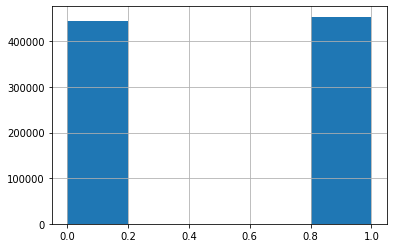

In [10]:
# Plot histogram of FinalWinner column
df.FinalWinner.hist(bins=5)

# <font color='green'>Feature selection</font>

In [11]:
target = "FinalWinner"

In [12]:
global_features = ["RegularTime", "SpikeTime"]
team_features = ["loadoutValue", "operators", "Initiator", "Duelist", "Sentinel", "Controller"]
atk_features = [f"ATK_{i}" for i in team_features]
def_features = [f"DEF_{i}" for i in team_features]

In [13]:
full_features = global_features + atk_features + def_features

In [14]:
full_features

['RegularTime',
 'SpikeTime',
 'ATK_loadoutValue',
 'ATK_operators',
 'ATK_Initiator',
 'ATK_Duelist',
 'ATK_Sentinel',
 'ATK_Controller',
 'DEF_loadoutValue',
 'DEF_operators',
 'DEF_Initiator',
 'DEF_Duelist',
 'DEF_Sentinel',
 'DEF_Controller']

# <font color='yellow'>Train</font>

In [15]:
X = df[full_features]
Y = df[target]

In [16]:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=32,
                       colsample_bytree=0.2, reg_alpha=3, reg_lambda=1,
                       min_split_gain=0.01, min_child_weight=40, verbose=-1)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
model.fit(X_train, Y_train)

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.05, min_child_weight=40,
               min_split_gain=0.01, n_estimators=1000, num_leaves=32,
               reg_alpha=3, reg_lambda=1, verbose=-1)

# <font color='yellow'>Metrics</font>

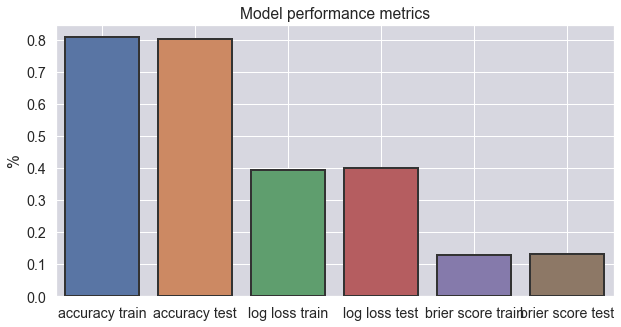

In [22]:
plt.figure(figsize=(10, 5))
pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)
gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                             log_loss(Y_train, pred_proba), log_loss(Y_test, pred_proba_test),
                             brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),
                             brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]}
sns.set_context(rc={'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3,
                         palette=sns.color_palette("deep"))

plt.ylabel('%')
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Model performance metrics")
plt.show()

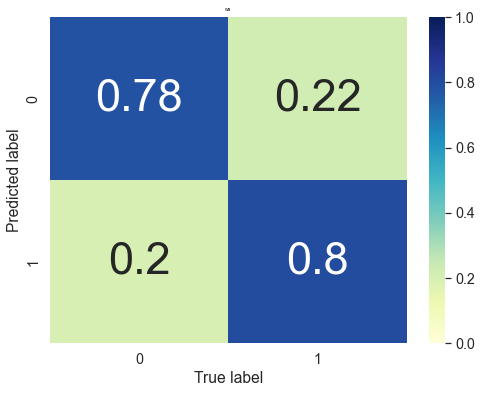

In [24]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm / cm.sum(axis=1).reshape(-1, 1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size': 45})
plt.title("wa", fontsize=5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()